In [17]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL

import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [18]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

#seg = pd.read_csv(PATH/MASKS)
#seg_aug = pd.read_csv('../aug/augment.csv', header=None)
#seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
#train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [19]:
#len(seg),len(seg_aug)

In [20]:
#df = pd.merge(seg, seg_aug,'outer'); len(df)
df = pd.read_csv(PATH/'trainRGB.csv'); len(df)

99165

In [21]:
def darknet444_3c(pretrained=True):
    if pretrained:
        m = Darknet([1,2,4,4,4], 28, 32, se=True, nf_in=4)
        model = create_body(m)
        sd = torch.load('models/dk_444_se_256.pth', map_location=lambda storage, loc: storage)
        names = set(model.state_dict().keys())
        for n in list(sd.keys()): # list "detatches" the iterator
                if n not in names and n+'_raw' in names:
                    if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
                    del sd[n]
        model.load_state_dict(sd, strict=True)
        weight = model.layers[0][0].weight
        model.layers[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        model.layers[0][0].weight = nn.Parameter(weight[:, :3, :,:])
    else:
        model = Darknet([1,2,4,4,4], 28, 32, se=True, nf_in=3)
        apply_init(model, nn.init.kaiming_normal_)
    return model.layers

In [22]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_warp=0.4)

In [23]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test_folder(TEST))
    data = (src.transform(tfms, size=sz))
    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl, val_dl, test_dl).normalize(stats)

In [24]:
data = get_data()

In [25]:
data.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27']

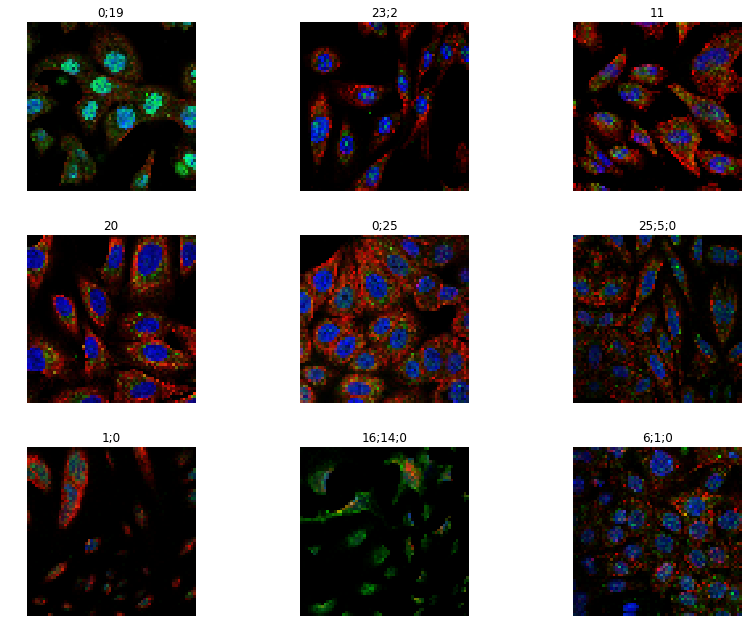

In [26]:
data.show_batch(rows=3, figsize=(12,9))

In [27]:
def get_learner(data, focal=False, fp16=False):
    def _dark_split(m): return (m[0][11],m[0][20])
    learn = create_cnn(data, darknet444_3c, pretrained=True, cut=-3, split_on=_dark_split, metrics=[accuracy_thresh, f1], callback_fns=[partial(GradientClipping, clip=0.1), BnFreeze, ShowGraph])
    if focal: 
        learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16()
    return learn.mixup(stack_y=False)

# 256

In [28]:
data = get_data(256, 128, sample=None)

In [29]:
learn = get_learner(data, focal=True, fp16=True)

In [30]:
learn.model = nn.DataParallel(learn.model)
learn.load('dk_444_se_256_3c')
learn.data.train_dl.add_tfm(to_half)
learn.data.test_dl.add_tfm(to_half)
learn.data.valid_dl.add_tfm(to_half)

In [16]:
len(learn.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


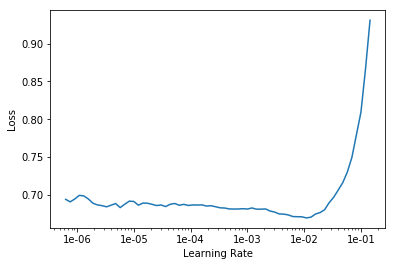

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr=5e-3

In [17]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.619410,0.539902,0.973695,0.519037


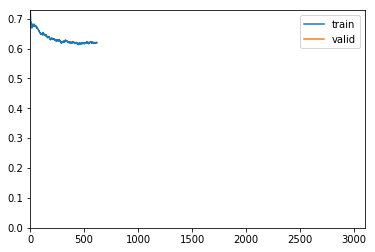

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 240, in _fee

KeyboardInterrupt: 

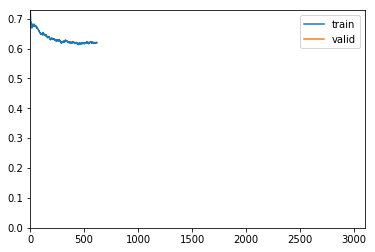

In [18]:
%time learn.fit_one_cycle(5, slice(lr))

In [19]:
learn.save('dk_444_se_256_3c');

In [21]:
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(5 slice(lr/100, lr/10))

In [ ]:
%time learn.fit_one_cycle(5, slice(lr/100, lr/10)))

In [ ]:
learn.save('dk_444_se_256_3c');

In [ ]:
learn = get_learner(data, focal=True, fp16=True)
learn.load('dk_444_se_256_3c');
learn.unfreeze()

In [ ]:
%time learn.fit_one_cycle(5, slice(lr/100, lr/10))

In [ ]:
%time learn.fit_one_cycle(5, slice(lr/100, lr/10))

In [ ]:
%time learn.fit_one_cycle(5, slice(lr/100, lr/10))

In [ ]:
%time learn.fit_one_cycle(5, slice(lr/100, lr/10))

In [ ]:
learn.save('dk_444_se_256_3c');

# Validation and Preds

In [ ]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
p.shape

Compute optimal THS

In [ ]:
#train data preds
learn.data.train_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds(ds_type=DatasetType.Train)

In [ ]:
p_v[0]>0

In [ ]:
t_v[0]

In [ ]:
p_v_s = p_v.sigmoid()
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [ ]:
ths = find_thresh(p_v_np, t_v_np); ths

In [ ]:
ths=array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

In [ ]:
f1_np(p_v_np, t_v_np, ths)

# Sub File

In [ ]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
# classes = np.array(data.classes)
classes = array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

In [ ]:
classes

In [ ]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [ ]:
frame.head()